# Sberbank Russian Housing Market
---

### TOC: 
- [Загружаем необходимые библиотеки и данные](#data)
- [Cross-validation](#cross)
- [Feature engineering](#engineering)
- [Models](#models):
    * [Model 1](#1)
    * [Model 2](#2)
- [HeatMap](#heatmap)
    * [Model 3](#3)
    * [Model 4](#4)
    * [Model 5](#5)
    * [Model 6](#6)
- [Сравнение результатов](#compare)
    * [Выводы](#conclusion)

## Загружаем необходимые библиотеки и данные <a class="anchor" id="data"></a> 
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

In [2]:
train = pd.read_csv('../data/raw/train.csv')
test  = pd.read_csv('../data/raw/test.csv')

## Cross-validation <a class="anchor" id="cross"></a>
---

$$ MSE =  \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat {y_i})^2 $$

$$ MSLE = \frac{1}{n} \sum_{i=1}^{n} (\log{(y_i+1)} - \log{\hat{y_i}+1})^2 $$

In [3]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso

In [4]:
def cross_validation(data, features, target):
    mse_list = []
    msle_list = []
    i = 1
    
    kf = KFold( n_splits=5, shuffle = True ) 
    for train_index, val_index in kf.split(data):
        train_part = data.loc[train_index, :]
        val_part = data.loc[val_index, :]
        
# Путем перебора различных моделей было принято решение использовать именно Lasso()        
#         model = SGDRegressor()
#         model = ElasticNet()
        model = Lasso()
        model.fit( X = train_part[features], y = train_part[target] )
        val_prediction = model.predict( val_part[features] ).clip( 0, 10**10)
        
        mse = mean_squared_error( val_part[target], val_prediction )
        msle = mean_squared_log_error( val_part[target], val_prediction )
    
        mse_list.append(mse)
        msle_list.append(msle)
        
        print( f'Fold {i}: MSLE: {msle} , MSE: {mse}')
        i += 1
    print( f'MSLE average = {np.mean(msle_list)} , std = {np.std(msle_list)} ' )
    print( f'RMSLE = {np.sqrt(msle_list)} \n RMSLE avg = {np.mean(np.sqrt(msle_list))} ' )

## Feature engineering <a class="anchor" id="engineering"></a> 
---

После 2 модели построен HeatMap, для которого мы дублируем создание фичей в самом начале notebook 

По умолчанию, начиная с 3 модели, мы каждый раз испортируем данные заново, чтобы избежать возможных последствий от преоразований в предыдущих моделях (особенно после преобразования Бокса-Кокса)

In [5]:
train['price_m2'] = train['price_doc'] / (train['full_sq'] + 1)
train['price_m2'].clip( train['price_m2'].quantile(0.01), train['price_m2'].quantile(0.99))

train['life_part'] = train['life_sq'] / (train['full_sq'] + 1)
test['life_part'] = test['life_sq'] / (test['full_sq'] + 1)

train['kitch_part'] = train['kitch_sq'] / (train['full_sq'] + 1)
test['kitch_part'] = test['kitch_sq'] / (test['full_sq'] + 1)

train['floor_part'] = train['floor'] / (train['max_floor'] + 1)
test['floor_part'] = test['floor'] / (test['max_floor'] + 1)

In [6]:
# категориальный признак product_type заменяем бинарными значениями 0 и 1
train['product_type'] = train['product_type'].replace({ 'Investment':1, 'OwnerOccupier': 0 })
test['product_type'] = test['product_type'].replace({ 'Investment':1, 'OwnerOccupier':0 })

In [7]:
# timestamp
def get_date_time_features(timestamp_series: pd.Series) -> pd.DataFrame:
    
    timestamp_series = pd.to_datetime(timestamp_series)
    
    output= pd.DataFrame()
    output['timestamp']= timestamp_series
    output['year'] = timestamp_series.dt.year.astype(np.int16)
    output['month'] = timestamp_series.dt.month.astype(np.int8)
    output['day_week'] = timestamp_series.dt.dayofweek.astype(np.int8)
    output['day_month_datetime'] =timestamp_series.dt.day.astype(np.int8)
    output['seconds'] = timestamp_series.astype(int)/1_000_000_000_000 
    
    return output  

train = pd.concat( [train, get_date_time_features(train['timestamp'])] , axis=1 )
test = pd.concat( [test, get_date_time_features(test['timestamp'])] , axis=1 )

/var/folders/38/bgjzx19n7z50tbjs_n3vpgdw0000gn/T/ipykernel_1031/597945142.py:12: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  output['seconds'] = timestamp_series.astype(int)/1_000_000_000_000


## Models <a class="anchor" id="models"></a> 
---

**Model 1.** <a class="anchor" id="1"></a> Используем только непрерывные признаки

In [8]:
features_1 = ['metro_km_walk', 'kremlin_km', 'life_part', 'green_zone_part']
target = 'price_doc'

train[features_1] = train[features_1].fillna(0)
test[features_1] = test[features_1].fillna(0)

cross_validation(train, features_1, target)
              
model_1 = Lasso()
model_1.fit(X = train[features_1], y = train[target])

Fold 1: MSLE: 0.3812552626360196 , MSE: 19191591809265.9
Fold 2: MSLE: 0.38311588215071746 , MSE: 20417086701835.594
Fold 3: MSLE: 0.37912486289762853 , MSE: 22774509389408.09
Fold 4: MSLE: 0.3732962664609026 , MSE: 21373823746578.71
Fold 5: MSLE: 0.40408909223410266 , MSE: 21206537736880.63
MSLE average = 0.38417627327587417 , std = 0.010488740500774292 
RMSLE = [0.61745871 0.61896355 0.61573116 0.61097976 0.63568002] 
 RMSLE avg = 0.6197626424455897 


Lasso()

In [9]:
sample_submission = pd.read_csv('../data/raw/sample_submission.csv')  
sample_submission['price_doc']= model_1.predict(test[features_1]).clip(0.001, 100000000000)
sample_submission.to_csv('model_1.csv', index = False) 

In [10]:
!kaggle competitions submit -c sberbank-russian-housing-market -f model_1.csv -m "hw_model_1"

100%|████████████████████████████████████████| 179k/179k [00:03<00:00, 54.4kB/s]
Successfully submitted to Sberbank Russian Housing Market

**Model 2.** <a class="anchor" id="2"></a> Нормируем признаки из первой модели при помощи преобразования Бокса-Кокса

$$
y(\lambda) = 
\begin{cases} 
\frac {(y^{\lambda} - 1)}{\lambda} & \lambda \neq 0
\\\log(y) & \lambda = 0
\end{cases}
$$

In [11]:
import scipy.stats as stats

def normal_boxcox(data, features):
    for feature in features: 
        data[feature] = data[feature].clip(0.0000001, 10**10)
        data[feature] = stats.boxcox(data[feature])[0]

In [12]:
features_2 = ['metro_km_walk', 'kremlin_km', 'life_part', 'green_zone_part']
target = 'price_doc'

normal_boxcox(train, features_2)
normal_boxcox(test, features_2)

cross_validation(train, features_2, target)

model_2 = Lasso()
model_2.fit(X = train[features_2], y = train[target])

Fold 1: MSLE: 0.3800700032110566 , MSE: 19842356883074.0
Fold 2: MSLE: 0.35743982109205075 , MSE: 19320804312990.652
Fold 3: MSLE: 0.37802772888125835 , MSE: 24148324376868.785
Fold 4: MSLE: 0.3731038972802192 , MSE: 20787649215112.934
Fold 5: MSLE: 0.37971113480074886 , MSE: 20487894580229.633
MSLE average = 0.37367051705306675 , std = 0.008487453447549172 
RMSLE = [0.61649818 0.59786271 0.6148396  0.61082231 0.61620706] 
 RMSLE avg = 0.6112459704496996 


Lasso()

In [13]:
sample_submission = pd.read_csv('../data/raw/sample_submission.csv')  
sample_submission['price_doc']= model_2.predict(test[features_2]).clip(0.001, 100000000000)
sample_submission.to_csv('model_2.csv', index = False)

In [14]:
!kaggle competitions submit -c sberbank-russian-housing-market -f model_2.csv -m "hw_model_2"

100%|████████████████████████████████████████| 179k/179k [00:04<00:00, 41.6kB/s]
Successfully submitted to Sberbank Russian Housing Market

### Построим Тепловую карту для выявления зависимости фичей и таргет-переменной <a class="anchor" id="heatmap"></a>

Идея простая - если корреляция между фичами больше 0.6 по модулю, то для модели будет достаточно оставить только один из двух признаков.

In [15]:
all_features = [
    'metro_km_walk',
    'kremlin_km', 
    'green_zone_part',
    'full_sq',
    'life_part',
    'kitch_part',
    'floor_part',
    'product_type',
    'state',
    'sub_area',
    'ID_metro',
    'year',
    'month',
    'price_m2'
]

['metro_km_walk', 'kremlin_km', 'green_zone_part', 'full_sq', 'life_part', 'kitch_part', 'floor_part', 'product_type', 'state', 'sub_area', 'ID_metro', 'year', 'month', 'price_m2']


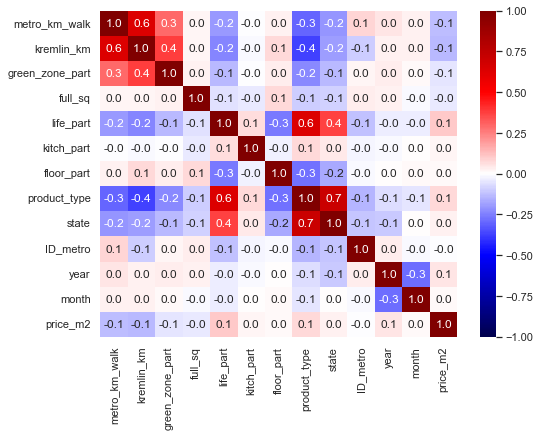

In [16]:
plt.figure(figsize=(8, 6))
sns.heatmap(train[all_features].corr(), annot = True, fmt = '.1f', cmap = 'seismic',
           vmin = -1, vmax = 1, center = 0);
print(all_features)

__Таким образом, приходим к следующему решению:__
- убрать из фичей признак __sub_area__ $\rightarrow$ наблюдается высокая корреляция с несколькими признаками (__`metro_km_walk`, `kremlin_km`, `ID_metro`__);
- убрать признак __kremlin_km__, так как он сильно коррелирует с __metro_km_walk__ и не оказывает существенного влияния на качество модели;
- внимательно изучить качество следующих моделей с использованием признака __product_type__, потому что он показывает корреляцию выше среднего по отношению к __life_part__.

**Model 3.** <a class="anchor" id="3"></a> <br>
Добавим категориальный признак `product_type` и создадим еще две фичи: `kitch_part`, `floor_part`.
Также `life_part` из предыдущих моделей заменим на просто `full_sq`.

In [17]:
# повторно импортирем данные, чтобы исключить последствие преобразования Бокса-Кокса,
# в ходе которого были изменены значения нескольких фичей
train = pd.read_csv('../data/raw/train.csv')
test  = pd.read_csv('../data/raw/test.csv')

# создаем новые фичи
train['kitch_part'] = train['kitch_sq'] / (train['full_sq'] + 1)
test['kitch_part'] = test['kitch_sq'] / (test['full_sq'] + 1)

train['floor_part'] = train['floor'] / (train['max_floor'] + 1)
test['floor_part'] = test['floor'] / (test['max_floor'] + 1)

In [18]:
# категориальный признак product_type заменяем бинарными значениями 0 и 1
train['product_type'] = train['product_type'].replace({ 'Investment':1, 'OwnerOccupier': 0 })
test['product_type'] = test['product_type'].replace({ 'Investment':1, 'OwnerOccupier':0 })

In [19]:
features_3 = ['metro_km_walk', 
              'full_sq', 
              'green_zone_part', 
              'product_type',
              'kitch_part',
              'floor_part'
             ]
target = 'price_doc'

# заполняем пропуски нулями
train[features_3] = train[features_3].fillna(0)
test[features_3] = test[features_3].fillna(0)

normal_boxcox(train, features_3)
normal_boxcox(test, features_3)

cross_validation(train, features_3, target)

Fold 1: MSLE: 1.3623261880707704 , MSE: 14720674562870.633
Fold 2: MSLE: 0.9392707652561328 , MSE: 13905070669924.863
Fold 3: MSLE: 1.154932991238917 , MSE: 12299738496985.176
Fold 4: MSLE: 0.9991842421129339 , MSE: 12066183886577.342
Fold 5: MSLE: 1.1677615442217937 , MSE: 15120349194910.492
MSLE average = 1.1246951461801094 , std = 0.1479004679268636 
RMSLE = [1.1671873  0.96915982 1.07467809 0.99959204 1.08063016] 
 RMSLE avg = 1.0582494815970236 


In [20]:
model_3 = Lasso()
model_3.fit(X = train[features_3], y = train[target])

sample_submission = pd.read_csv('../data/raw/sample_submission.csv')  
sample_submission['price_doc']= model_3.predict(test[features_3]).clip(0.001, 100000000000)
sample_submission.to_csv('model_3.csv', index = False)

!kaggle competitions submit -c sberbank-russian-housing-market -f model_3.csv -m "hw_model_3"

100%|████████████████████████████████████████| 182k/182k [00:04<00:00, 46.4kB/s]
Successfully submitted to Sberbank Russian Housing Market

**Model 4.** <a class="anchor" id="4"></a> <br>
Делаем encoding для фичей `ID_metro`, `state` , `product_type`

In [21]:
train = pd.read_csv('../data/raw/train.csv')
test  = pd.read_csv('../data/raw/test.csv')

In [22]:
def target_encoding(train, test,  encoding_features, target):
    for feature in encoding_features:
        encoding_features = train.groupby([feature])[target].mean()
        train[feature] = train[feature].replace(encoding_features) 
        test[feature] = test[feature].replace(encoding_features)

        train[feature] = train[feature].fillna(train[feature].mean())
        test[feature] = test[feature].fillna(test[feature].mean())

encoding_features = ['ID_metro', 'state', 'product_type']        
target_encoding(train, test, encoding_features, target)

In [23]:
target = 'price_doc'
features_4 = ['metro_km_walk', 
              'full_sq', 
              'green_zone_part'
             ] + encoding_features

# заполним пропуски не нулями, а средним значением
train[features_4] = train[features_4].fillna(train[features_4].mean())
test[features_4] = test[features_4].fillna(test[features_4].mean())

cross_validation(train, features_4, target)

Fold 1: MSLE: 0.6838405025643165 , MSE: 57873833083064.586
Fold 2: MSLE: 0.2940067393797696 , MSE: 14048139997684.477
Fold 3: MSLE: 0.27247426295355326 , MSE: 12552565525211.906
Fold 4: MSLE: 0.27049974090779283 , MSE: 13301185573814.506
Fold 5: MSLE: 0.29318415252467983 , MSE: 14070144875869.908
MSLE average = 0.36280107966602243 , std = 0.16082534614224395 
RMSLE = [0.82694649 0.54222388 0.52199067 0.5200959  0.54146482] 
 RMSLE avg = 0.5905443533000251 


In [24]:
model_4 = Lasso()
model_4.fit(X = train[features_4], y = train[target])

sample_submission = pd.read_csv('../data/raw/sample_submission.csv')  
sample_submission['price_doc']= model_4.predict(test[features_4]).clip(0.001, 100000000000)
sample_submission.to_csv('model_4.csv', index = False)

!kaggle competitions submit -c sberbank-russian-housing-market -f model_4.csv -m "hw_model_4"

100%|████████████████████████████████████████| 180k/180k [00:03<00:00, 55.4kB/s]
Successfully submitted to Sberbank Russian Housing Market

**Model 5.** <a class="anchor" id="5"></a> <br>
Добавляем __timestamp__ к фичам из модели 4.

In [25]:
train = pd.read_csv('../data/raw/train.csv')
test  = pd.read_csv('../data/raw/test.csv')

In [26]:
# timestamp
def get_date_time_features(timestamp_series: pd.Series) -> pd.DataFrame:
    
    timestamp_series = pd.to_datetime(timestamp_series)
    
    output= pd.DataFrame()
    output['timestamp']= timestamp_series
    output['year'] = timestamp_series.dt.year.astype(np.int16)
    output['month'] = timestamp_series.dt.month.astype(np.int8)
    output['day_week'] = timestamp_series.dt.dayofweek.astype(np.int8)
    output['day_month_datetime'] =timestamp_series.dt.day.astype(np.int8)
    output['seconds'] = timestamp_series.astype(int)/1_000_000_000_000 
    
    return output  

train = pd.concat( [train, get_date_time_features(train['timestamp'])] , axis=1 )
test = pd.concat( [test, get_date_time_features(test['timestamp'])] , axis=1 )

/var/folders/38/bgjzx19n7z50tbjs_n3vpgdw0000gn/T/ipykernel_1031/597945142.py:12: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  output['seconds'] = timestamp_series.astype(int)/1_000_000_000_000


In [27]:
encoding_features = ['ID_metro', 'state', 'product_type']
target_encoding(train, test, encoding_features, target)

In [28]:
target = 'price_doc'
features_5 = ['metro_km_walk', 
              'full_sq', 
              'green_zone_part',
              'year',
              'month'
             ] + encoding_features

# заполняем пропуски средним значением
train[features_5] = train[features_5].fillna(train[features_5].mean())
test[features_5] = test[features_5].fillna(test[features_5].mean())

cross_validation(train, features_5, target)

Fold 1: MSLE: 0.266574262051245 , MSE: 11767879283699.758
Fold 2: MSLE: 0.2885920797094279 , MSE: 13414571263404.34
Fold 3: MSLE: 0.26156386802880416 , MSE: 13268422695848.367
Fold 4: MSLE: 0.42253825221321295 , MSE: 57352135376941.6
Fold 5: MSLE: 0.29009518131463463 , MSE: 14480984308963.646
MSLE average = 0.30587272866346493 , std = 0.059440795456601365 
RMSLE = [0.5163083  0.53720767 0.51143315 0.65002942 0.53860485] 
 RMSLE avg = 0.5507166785447197 


In [29]:
model_5 = Lasso()
model_5.fit(X = train[features_5], y = train[target])

sample_submission = pd.read_csv('../data/raw/sample_submission.csv')  
sample_submission['price_doc']= model_5.predict(test[features_5]).clip(0.001, 100000000000)
sample_submission.to_csv('model_5.csv', index = False)

!kaggle competitions submit -c sberbank-russian-housing-market -f model_5.csv -m "hw_model_5"

100%|████████████████████████████████████████| 180k/180k [00:04<00:00, 41.1kB/s]
Successfully submitted to Sberbank Russian Housing Market

**Model 6.** <a class="anchor" id="6"></a> <br>
Объединим фичи из модели 5, но поменяем таргет.

In [30]:
# чтобы избежать ненужных преобразований от предыдущих моделей, заново импортируем данные
train = pd.read_csv('../data/raw/train.csv')
test  = pd.read_csv('../data/raw/test.csv')

# создаем новый таргет
train['price_m2'] = train['price_doc'] / (train['full_sq'] + 1)
train['price_m2'].clip( train['price_m2'].quantile(0.01), train['price_m2'].quantile(0.99))

# timestamp
def get_date_time_features(timestamp_series: pd.Series) -> pd.DataFrame:
    
    timestamp_series = pd.to_datetime(timestamp_series)
    
    output= pd.DataFrame()
    output['timestamp']= timestamp_series
    output['year'] = timestamp_series.dt.year.astype(np.int16)
    output['month'] = timestamp_series.dt.month.astype(np.int8)
    
    return output  

train = pd.concat( [train, get_date_time_features(train['timestamp'])] , axis=1 )
test = pd.concat( [test, get_date_time_features(test['timestamp'])] , axis=1 )

# повторяем encoding
encoding_features = ['ID_metro', 'state', 'product_type']
target_encoding(train, test, encoding_features, target)


target = 'price_m2'
features_6 = ['metro_km_walk', 
              'full_sq', 
              'green_zone_part',
              'year',
              'month'
             ] + encoding_features

# заполняем пропуски средним значением
train[features_6] = train[features_6].fillna(train[features_6].mean())
test[features_6] = test[features_6].fillna(test[features_6].mean())

cross_validation(train, features_6, target)

Fold 1: MSLE: 0.2929256677645214 , MSE: 25478129026.66221
Fold 2: MSLE: 0.5372588073449915 , MSE: 16353153271.578365
Fold 3: MSLE: 0.26743915462944157 , MSE: 43078089992.771996
Fold 4: MSLE: 0.34242821683579117 , MSE: 16587463108.420614
Fold 5: MSLE: 0.27094403781996534 , MSE: 37282541855.90893
MSLE average = 0.3421991768789422 , std = 0.10113609283175065 
RMSLE = [0.54122608 0.7329794  0.5171452  0.58517366 0.52052285] 
 RMSLE avg = 0.5794094387592723 


In [31]:
model_6 = Lasso()
model_6.fit(X = train[features_6], y = train[target])

sample_submission = pd.read_csv('../data/raw/sample_submission.csv') 
test_prediction = model_6.predict(test[features_6])

test_predict_transformation = test_prediction * ( test['full_sq'] + 1 )

In [32]:
sample_submission['price_doc']= test_predict_transformation.clip(0.001, 100000000000)
sample_submission.to_csv('model_6.csv', index = False)

!kaggle competitions submit -c sberbank-russian-housing-market -f model_6.csv -m "hw_model_6"

100%|████████████████████████████████████████| 181k/181k [00:03<00:00, 52.9kB/s]
Successfully submitted to Sberbank Russian Housing Market

## Сравнение результатов <a class="anchor" id="compare"></a> 
---

In [39]:
model = ['1', '2', '3', '4', '5', '6']
kaggel_public = [
    0.48895, 
    0.49107,
    0.59074,
    0.49899,
    0.45956,
    0.40040
]

kaggle_private = [
    0.49194,
    0.49321,
    0.64340,
    0.45985,
    0.45734,
    0.40490
]


RMSLE = [
    0.6197626424455897,
    0.6112459704496996,
    1.0582494815970236,
    0.5905443533000251,
    0.5507166785447197,
    0.579409438759272
]

score_dt = pd.DataFrame({'model': model, 'kaggle_public': kaggel_public, 
                         'kaggle_pivate': kaggle_private,'rmsle': RMSLE})
score_dt

model  kaggle_public  kaggle_pivate     rmsle
0     1        0.48895        0.49194  0.619763
1     2        0.49107        0.49321  0.611246
2     3        0.59074        0.64340  1.058249
3     4        0.49899        0.45985  0.590544
4     5        0.45956        0.45734  0.550717
5     6        0.40040        0.40490  0.579409

<Figure size 504x360 with 0 Axes>

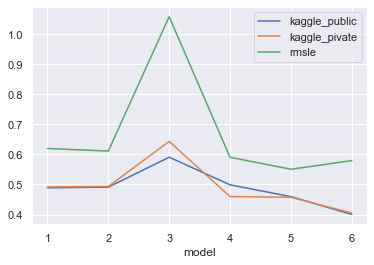

In [40]:
plt.figure(figsize=(7, 5))
score_dt.plot(x = 'model', y = ['kaggle_public', 'kaggle_pivate', 'rmsle'])
plt.show();

### Выводы: <a class="anchor" id="conclusion"></a> 

1. Значительно отличается качество модели #3. Там был добавлен категориальный признак `product_type` и еще 2 новых признака: `kitchen_part` и `floor_part`. Даже преобразование Бокса-Кокса особенно не помогло спасти ситуацию. Для чистоты эксперимента, в следующих моделях `kitchen_part` и `floor_part` были убраны, а `product_type` прогонялся через __encoding__


2. Добавление __target encoding__ в 4 модели позволило улучшить скор (по RMSLE) по сравнению со второй моделью, где применялось преобразование Бокса-Кокса для улучшения метрики. Kaggle дал неоднозначный результат: Public score немного ухудшился по сравнению с моделью #2, в то время как Private score наоборот - значительно улучшился. Скорее всего подобный результат связан с тем, что для Public score и Private score используют разные выборки


3. В модели #5 были добавлены __timestamp__: year и month, они также улучшили качество модели


4. Самый значительный скачок по качеству модели произошел в модели #6, где был заменен таргет на `price_m2`. Что не удивительно, так как логичнее предсказывать стоимость за 1 кв.м, а потом домножать на полную площадь квартиры. 


5. Преобразование Бокса-Кокса немного улучшает качество модели только при использовании непрерывных признаков (в простой модели), для более сложных моделей это уже не работает


6. Одназначно в модель стоит включать __target encoding__ и __timestamp__, но всегда стоит понимать, что очень многое будет зависеть от корректно подобранного таргета